<h1 align="center">3.1 Feature Engeneering (Shops)</h1>
<h3 align="center">Dataset: <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Predict future sales</a></h3>

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim # pacman -S python-geopy
#from mpl_toolkits.basemap import Basemap # pacman -S python-basemap

from itertools import product
from collections import Counter
from sklearn.cluster import KMeans

### Constants

In [2]:
ENGLISH = True

DATA_RUS_PATH = "../DATA/1. Original data Russian (96Mb)/"
DATA_ENG_PATH = "../DATA/2. Translated data English (1Mb)/"
DATA_FE_PATH  = "../DATA/3. Feature Engeneering/"
DATA_SUB_PATH = "../DATA/5. Submissions/"

### Load data

In [3]:
sales = pd.read_csv(DATA_RUS_PATH + "sales_train.csv")          # Dayly sales  Jan 2013 -> Oct 2015
test  = pd.read_csv(DATA_RUS_PATH + "test.csv", index_col="ID") # Predict Noviember 2015
sub   = pd.read_csv(DATA_RUS_PATH + "sample_submission.csv", index_col="ID")

if ENGLISH: 
    shops = pd.read_csv(DATA_ENG_PATH + "shops.csv", index_col="shop_id") # shops    (60)
    items = pd.read_csv(DATA_ENG_PATH + "items.csv")           # products  (22170)
    cats  = pd.read_csv(DATA_ENG_PATH + "item_categories.csv") # product categories (84)

else:
    shops = pd.read_csv(DATA_RUS_PATH + "shops.csv", index_col="shop_id")           # shops    (60)
    items = pd.read_csv(DATA_RUS_PATH + "items.csv")           # products  (22170)
    cats  = pd.read_csv(DATA_RUS_PATH + "item_categories.csv") # product categories (84)

### Shops

In [4]:
shops.head(3)

,shop_name
shop_id,
0,Yakutsk Ordzhonikidze - 56 francs
1,Yakutsk TC Central fran
2,Adygea TC Mega


### Lowercase

In [5]:
shops['shop_name'] = shops['shop_name'].str.lower()
# shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')
shops.head(3)

,shop_name
shop_id,
0,yakutsk ordzhonikidze - 56 francs
1,yakutsk tc central fran
2,adygea tc mega


### Shop type

In [6]:
"""
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'МТРЦ' if 'МТРЦ' in x
                                              else 'ТРЦ' if 'ТРЦ' in x
                                              else 'ТРК' if 'ТРК' in x
                                              else 'ТЦ' if 'ТЦ' in x
                                              else 'ТК' if 'ТК' in x
                                              else 'NO_DATA')
""";

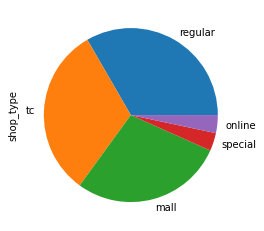

In [7]:
shops['shop_type'] = 'regular' # By default all shops are regular shops

#there is some overlap in tc and mall, mall is given precedence
shops.loc[ shops['shop_name'].str.contains(r'tc'), 'shop_type' ]               = 'tc'
shops.loc[ shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type' ] = 'mall'
shops.loc[ shops.index.isin([9,20]), 'shop_type' ]                             = 'special'
shops.loc[ shops.index.isin([12,55]), 'shop_type' ]                            = 'online'

shops['shop_type'].value_counts().plot.pie();

### Shop city

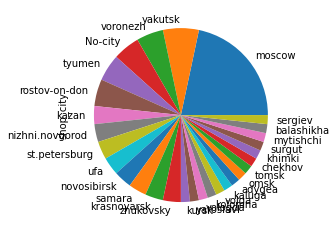

In [8]:
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops.index.isin([9,12,55]), 'shop_city'] = 'No-city'

shops['shop_city'].value_counts().plot.pie();

### Latitude & Longitude

In [9]:
cities = pd.DataFrame(shops['shop_city'].unique(), columns=["shop_city"])
shops['shop_city'].unique()

array(['yakutsk', 'adygea', 'balashikha', 'volga', 'vologda', 'voronezh',
       'No-city', 'zhukovsky', 'kazan', 'kaluga', 'kolomna',
       'krasnoyarsk', 'kursk', 'moscow', 'mytishchi', 'nizhni.novgorod',
       'novosibirsk', 'omsk', 'rostov-on-don', 'st.petersburg', 'samara',
       'sergiev', 'surgut', 'tomsk', 'tyumen', 'ufa', 'khimki', 'chekhov',
       'yaroslavl'], dtype=object)

In [10]:
def add_lat_lon(df):

    city = df["shop_city"]
    
    if city=="No-city":
        df['latitude']  = 0
        df['longitude'] = 0
        
    else:
        country ="Ru"
        geolocator = Nominatim(user_agent="my_user_agent")
        loc = geolocator.geocode(city+','+ country)
    
        if loc != None:
            df['latitude'] = loc.latitude
            df['longitude'] = loc.longitude
            
    return df

cities = cities.apply(add_lat_lon, axis=1)

In [11]:
cities

,shop_city,latitude,longitude
0,yakutsk,62.027287,129.732086
1,adygea,44.693901,40.152042
2,balashikha,55.803623,37.964649
3,volga,56.167024,44.215057
4,vologda,59.218876,39.893276
5,voronezh,51.660598,39.200586
6,No-city,0.000000,0.000000
7,zhukovsky,55.597280,38.119986
8,kazan,55.782355,49.124227
9,kaluga,54.510109,36.259811


In [12]:
fig = plt.figure(figsize=(14, 7))
m = Basemap(projection='lcc', resolution=None,
            width=6E6, height=3E6, 
            lon_0=75, lat_0=60)

m.etopo(scale=0.5, alpha=0.5)

for index, row in cities.iterrows():
    city_name = row["shop_city"]
    if city_name=="No-city": continue
    city_lat  = row["latitude"]
    city_lon  = row["longitude"]
    
    x, y = m(city_lon, city_lat) # Map (long, lat) to (x, y) for plotting
    plt.plot(x, y, 'ok', markersize=4)
    plt.text(x, y, city_name, fontsize=10);

NameError: name 'Basemap' is not defined

<Figure size 1008x504 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='lcc', resolution=None,
            width=0.8E6, height=0.4E6, 
            lon_0=40, lat_0=56)

m.etopo(scale=0.5, alpha=0.5)

for index, row in cities.iterrows():
    city_name = row["shop_city"]
    city_lat  = row["latitude"]
    city_lon  = row["longitude"]
    
    if city_name=="No-city": continue
    if city_lon<31 or 45<city_lon: continue
    if city_lat<54 or 59<city_lat: continue
    
    x, y = m(city_lon, city_lat) # Map (long, lat) to (x, y) for plotting
    plt.plot(x, y, 'ok', markersize=4)
    plt.text(x, y, city_name, fontsize=10);

### JOIN shops & cities

In [ ]:
shops = pd.merge(shops, cities, on="shop_city", how="left")
shops

### Categorical Encoding

In [ ]:
# Codificar las ciudades y los tipos de tienda
#shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city']) 
#shops['shop_type'] = LabelEncoder().fit_transform(shops['shop_type'])
#shops = shops[['shop_id', 'shop_city', 'shop_type']]
#shops.head()

### Save

In [ ]:
shops.to_csv(DATA_FE_PATH + "shops.csv")

# <center> EXTRA

### Training Dataframe (df)

In [ ]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

In [ ]:
sales_items = pd.merge(sales, items, on=['item_id'], how='left')
sales_items

In [ ]:


shop_cats   = sales_items.groupby(['item_category_id', 'shop_id']).agg({'item_cnt_day':'sum'}).unstack().fillna(0)

shop_cats

In [ ]:
shop_cats_norm = shop_cats / shop_cats.sum()

In [ ]:
sb.clustermap(shop_cats_norm.T, col_cluster=False, figsize=(10, 16))

In [ ]:
plt.figure(figsize=(10, 12))
sb.heatmap(shop_cats_norm.T)

In [ ]:
shop_cats_norm

In [ ]:
from sklearn.manifold import TSNE

shop_cats_tsne = TSNE(n_components=2, perplexity=10.0).fit_transform(shop_cats_norm.T)

sb.scatterplot(x=shop_cats_tsne[:,0], y=shop_cats_tsne[:,1])

In [ ]:
shops_cats = pd.DataFrame(
    np.array(list(product(*[shops['shop_id'].unique(), cats['item_category_id'].unique()]))),
    columns =['shop_id', 'item_category_id']
)

shops_cats

In [ ]:
price = train[['item_id', 'item_price']]
price = price.groupby(['item_id'])['item_price'].mean().reset_index()
price

price

In [ ]:
shopprice = train[['shop_id', 'item_id', 'item_price']]
shopprice = shopprice.groupby(['item_id', 'shop_id'])['item_price'].mean().reset_index()
shopprice

In [ ]:
testtmp = test.merge(shopprice, on=['item_id', 'shop_id'], how='left')
testtmp

In [ ]:
testtmp.loc[testtmp['item_price'].isnull(), 'item_price'] = df['Pclass'].map(price.item_price)

In [ ]:
price.head()